<a href="https://colab.research.google.com/github/nandini-n-123/MachineLearning/blob/main/MovieRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Uninstall NumPy completely
!pip uninstall -y numpy

# Step 2: Install compatible NumPy (1.26.4)
!pip install numpy==1.26.4

# Step 3: Restart runtime (automatically via JS)
import os
os.kill(os.getpid(), 9)


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 71.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2461567 sha256=561cd77d9cde45d6b26659344deae2380690afdb88afa5e1eb60dab3e81b0ff2
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader, SVD, accuracy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configure visualizations
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
ratings = pd.read_csv('/content/new_ratings.csv')
movies = pd.read_csv('/content/movies.csv')
tags = pd.read_csv('/content/tags.csv')
genome_scores = pd.read_csv('/content/new_genome-scores.csv')
genome_tags = pd.read_csv('/content/genome-tags.csv')

In [ ]:
# Dataset statistics
print("="*50)
print("Dataset Statistics")
print("="*50)
print(f"Ratings: {len(ratings):,} records")
print(f"Movies: {len(movies):,} unique movies")
print(f"Tags: {len(tags):,} user-applied tags")
print(f"Genome Scores: {len(genome_scores):,} tag relevance scores")
print(f"Time Range: {pd.to_datetime(ratings['timestamp'], unit='s').dt.year.min()} - "
      f"{pd.to_datetime(ratings['timestamp'], unit='s').dt.year.max()}")

Dataset Statistics
Ratings: 1,048,575 records
Movies: 62,423 unique movies
Tags: 1,093,360 user-applied tags
Genome Scores: 1,048,575 tag relevance scores
Time Range: 1995 - 2019


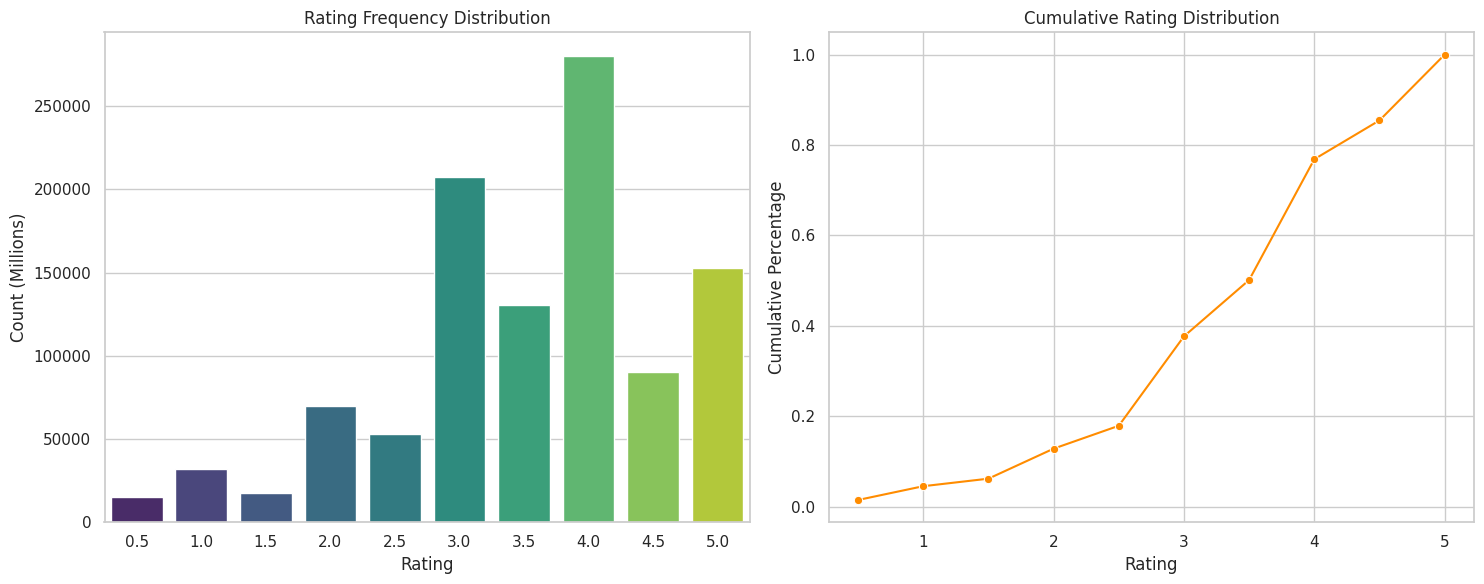

In [ ]:
# Rating distribution analysis
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
rating_dist = ratings['rating'].value_counts().sort_index()
sns.barplot(x=rating_dist.index, y=rating_dist.values, palette="viridis")
plt.title('Rating Frequency Distribution')
plt.xlabel('Rating')
plt.ylabel('Count (Millions)')

plt.subplot(1, 2, 2)
cumulative_dist = ratings['rating'].value_counts(normalize=True).sort_index().cumsum()
sns.lineplot(x=cumulative_dist.index, y=cumulative_dist.values, marker='o', color='darkorange')
plt.title('Cumulative Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Cumulative Percentage')
plt.grid(True)

plt.tight_layout()
plt.show()

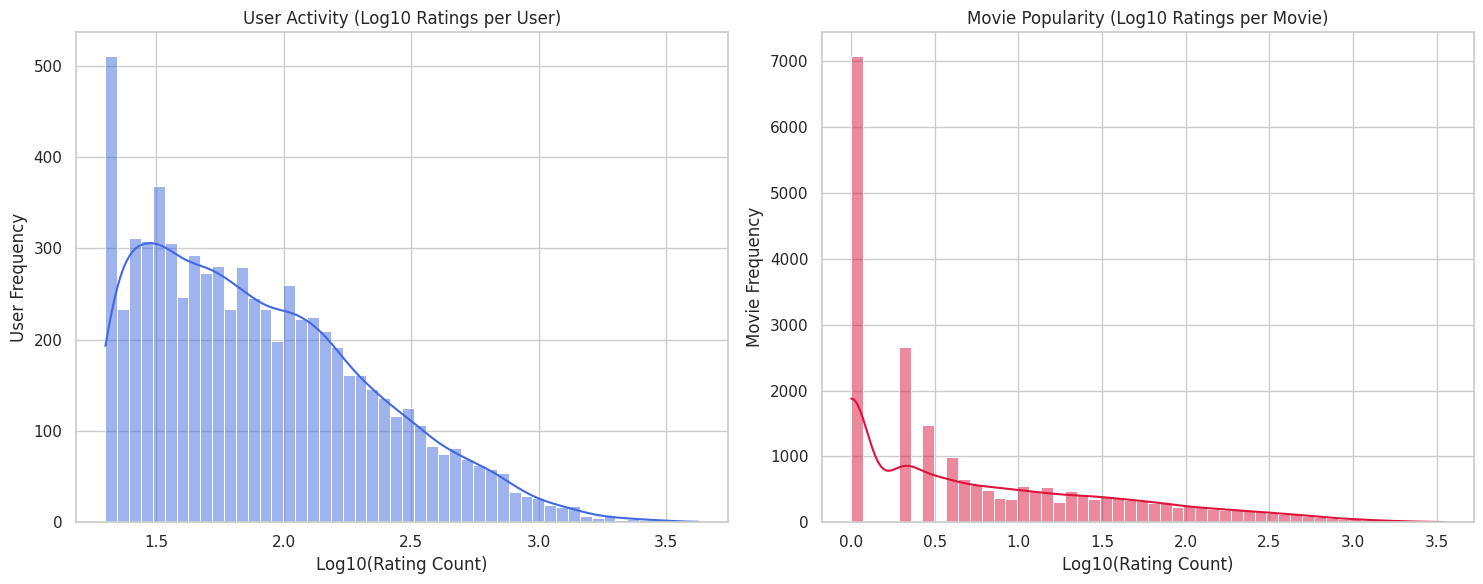

In [ ]:
# User and movie activity analysis
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
user_activity = ratings['userId'].value_counts()
sns.histplot(np.log10(user_activity), bins=50, kde=True, color='royalblue')
plt.title('User Activity (Log10 Ratings per User)')
plt.xlabel('Log10(Rating Count)')
plt.ylabel('User Frequency')

plt.subplot(1, 2, 2)
movie_popularity = ratings['movieId'].value_counts()
sns.histplot(np.log10(movie_popularity), bins=50, kde=True, color='crimson')
plt.title('Movie Popularity (Log10 Ratings per Movie)')
plt.xlabel('Log10(Rating Count)')
plt.ylabel('Movie Frequency')

plt.tight_layout()
plt.show()

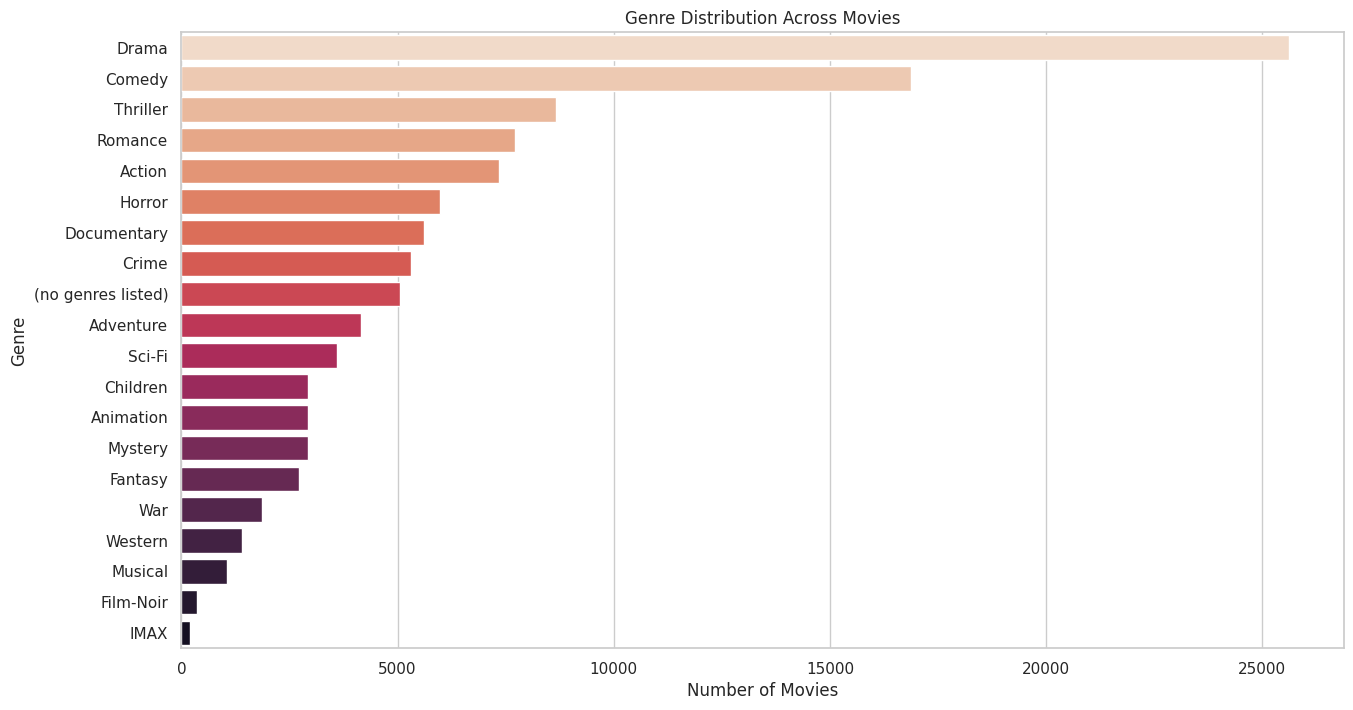

In [ ]:
# Genre analysis
movies['genres'] = movies['genres'].str.split('|')
exploded_genres = movies.explode('genres')

plt.figure(figsize=(15, 8))
genre_order = exploded_genres['genres'].value_counts().index
sns.countplot(y='genres', data=exploded_genres, order=genre_order, palette='rocket_r')
plt.title('Genre Distribution Across Movies')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

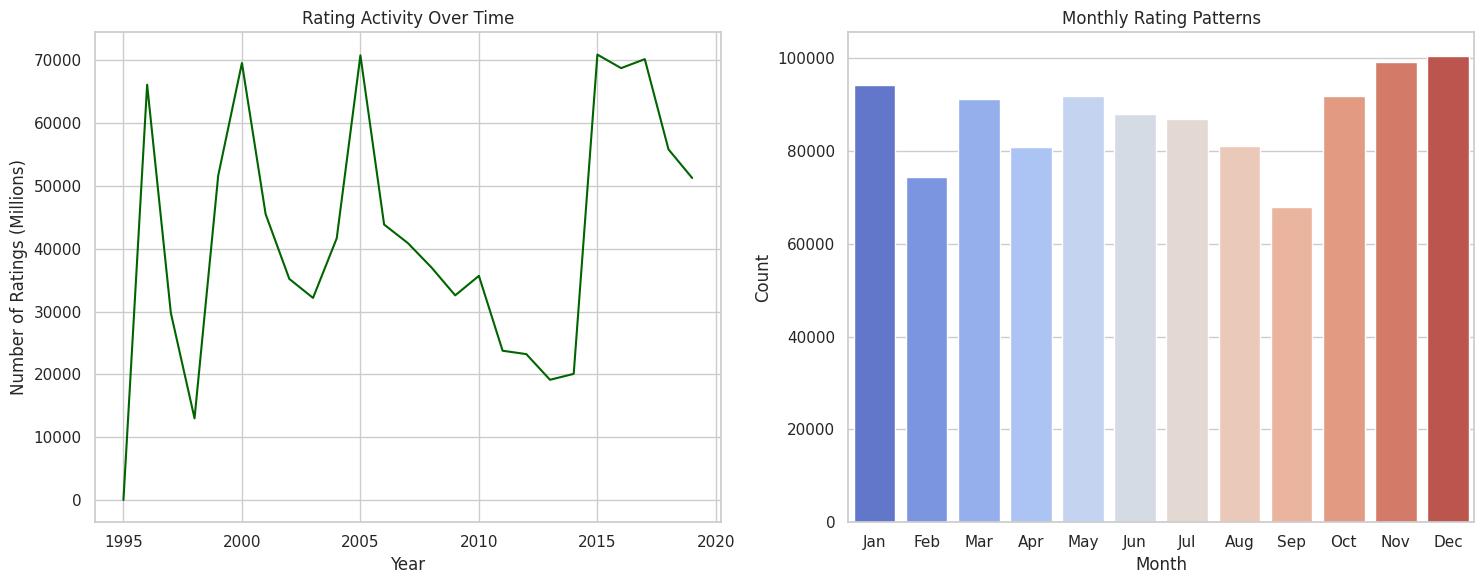

In [ ]:
# Temporal analysis
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
yearly_ratings = ratings.resample('Y', on='date')['rating'].count()
sns.lineplot(x=yearly_ratings.index.year, y=yearly_ratings.values, color='darkgreen')
plt.title('Rating Activity Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings (Millions)')

plt.subplot(1, 2, 2)
monthly_pattern = ratings.groupby(ratings['date'].dt.month)['rating'].count()
sns.barplot(x=monthly_pattern.index, y=monthly_pattern.values, palette='coolwarm')
plt.title('Monthly Rating Patterns')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

In [ ]:
# Merge genome data
genome_full = pd.merge(genome_scores, genome_tags, on='tagId')
movie_genome = genome_full.pivot(index='movieId', columns='tag', values='relevance').fillna(0)

# Movie feature engineering
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
genre_matrix = movies['genres'].str.join('|').str.get_dummies()

# Create comprehensive content features
content_features = pd.merge(
    movies[['movieId', 'release_year']],
    genre_matrix,
    left_index=True,
    right_index=True
)
content_features = pd.merge(content_features, movie_genome, on='movieId')

# Normalize features
scaler = MinMaxScaler()
content_features.iloc[:, 1:] = scaler.fit_transform(content_features.iloc[:, 1:])

In [ ]:
# Handle cold-start problem
MIN_RATINGS = 5
active_users = ratings['userId'].value_counts()[lambda x: x >= MIN_RATINGS].index
active_movies = ratings['movieId'].value_counts()[lambda x: x >= MIN_RATINGS].index

ratings = ratings[
    ratings['userId'].isin(active_users) &
    ratings['movieId'].isin(active_movies)
]

In [ ]:
# Time-based split
ratings = ratings.sort_values('timestamp')
train_size = int(0.7 * len(ratings))
val_size = int(0.15 * len(ratings))

train = ratings.iloc[:train_size]
val = ratings.iloc[train_size:train_size+val_size]
test = ratings.iloc[train_size+val_size:]

print("\nData split complete:")
print(f"Training: {len(train):,} records ({len(train)/len(ratings):.1%})")
print(f"Validation: {len(val):,} records ({len(val)/len(ratings):.1%})")
print(f"Test: {len(test):,} records ({len(test)/len(ratings):.1%})")


Data split complete:
Training: 719,429 records (70.0%)
Validation: 154,163 records (15.0%)
Test: 154,165 records (15.0%)



Training Basic SVD Model...


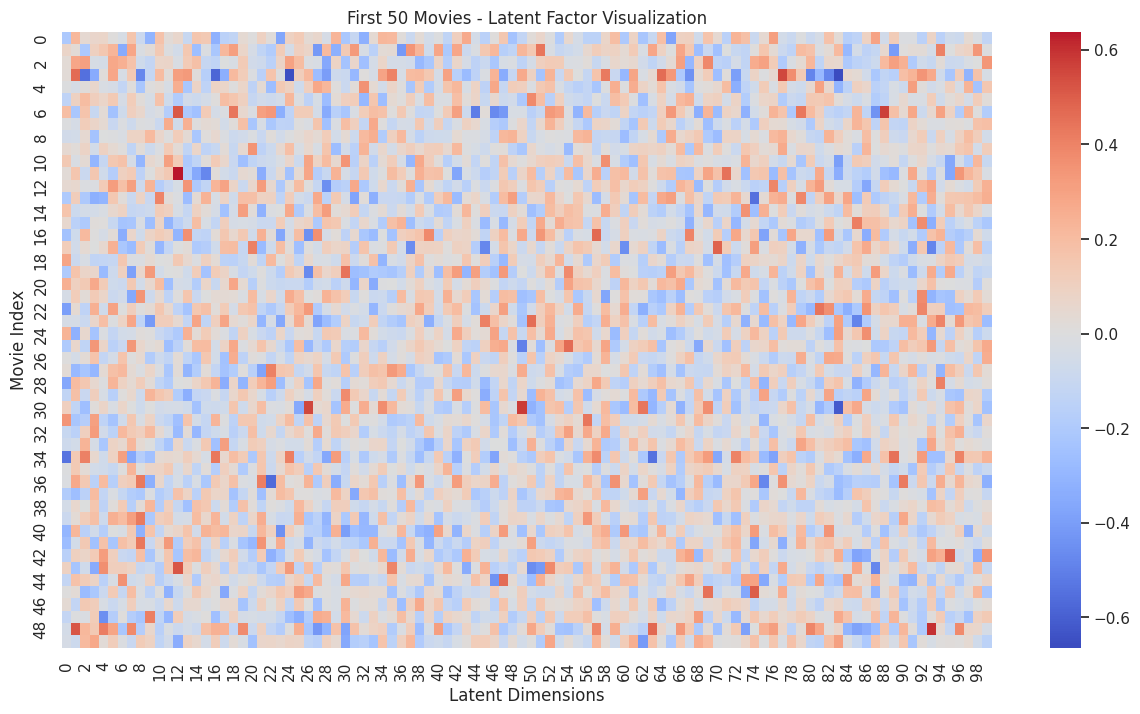

In [ ]:
# SVD model implementation
print("\nTraining Basic SVD Model...")
reader = Reader(rating_scale=(0.5, 5.0))
train_data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
trainset = train_data.build_full_trainset()

model_svd = SVD()
model_svd.fit(trainset)

# Latent factor visualization
plt.figure(figsize=(15, 8))
sns.heatmap(model_svd.qi[:50], cmap='coolwarm', center=0)
plt.title('First 50 Movies - Latent Factor Visualization')
plt.xlabel('Latent Dimensions')
plt.ylabel('Movie Index')
plt.show()

In [ ]:
# Model evaluation
def evaluate_svd(model, data):
    predictions = model.test(data[['userId', 'movieId', 'rating']].values)
    return {
        'RMSE': accuracy.rmse(predictions),
        'MAE': accuracy.mae(predictions)
    }

print("\nBasic SVD Performance:")
val_svd_metrics = evaluate_svd(model_svd, val)
print(f"Validation RMSE: {val_svd_metrics['RMSE']:.4f}")
print(f"Validation MAE: {val_svd_metrics['MAE']:.4f}")


Basic SVD Performance:
RMSE: 0.9951
MAE:  0.7542
Validation RMSE: 0.9951
Validation MAE: 0.7542


In [ ]:
# Hyperparameter tuning
print("\nPerforming Grid Search...")
param_grid = {
    'n_factors': [50, 100],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1],
    'n_epochs': [20, 30]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(train_data)

# Best model
model_tuned = gs.best_estimator['rmse']
model_tuned.fit(trainset)
print(f"\nBest Parameters: {gs.best_params['rmse']}")
print(f"Best Validation RMSE: {gs.best_score['rmse']:.4f}")


Performing Grid Search...

Best Parameters: {'n_factors': 100, 'lr_all': 0.01, 'reg_all': 0.1, 'n_epochs': 30}
Best Validation RMSE: 0.8385


In [ ]:
# Example recommendations
sample_user = train['userId'].sample(1).iloc[0]
print(f"\nTop 5 Recommendations for User {sample_user}:")
recommendations = generate_recommendations(sample_user, model_type='hybrid', n=5)
pd.merge(recommendations, movies, on='movieId')[['title', 'genres', 'predicted_rating']]


Top 5 Recommendations for User 4638:


NameError: name 'model_tuned' is not defined

In [ ]:
# Create user profile vectors by averaging features of positively rated movies
def get_user_profile(user_id, ratings_df, content_features_df, threshold=4.0):
    user_ratings = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['rating'] >= threshold)]
    if user_ratings.empty:
        return np.zeros(content_features_df.shape[1] - 1)

    rated_movie_ids = user_ratings['movieId']
    user_movies = content_features_df[content_features_df['movieId'].isin(rated_movie_ids)]
    return user_movies.iloc[:, 1:].mean().values

# Hybrid predict combines SVD prediction and content similarity
def hybrid_predict(user_id, movie_id, alpha=0.7):
    # SVD score
    svd_score = model_tuned.predict(user_id, movie_id).est

    # Content similarity score
    user_vector = get_user_profile(user_id, ratings, content_features)
    movie_vector = content_features[content_features['movieId'] == movie_id].iloc[:, 1:].values[0]
    content_score = np.dot(user_vector, movie_vector) / (np.linalg.norm(user_vector) * np.linalg.norm(movie_vector) + 1e-8)

    # Combine with weighted average
    return alpha * svd_score + (1 - alpha) * content_score


In [ ]:
def generate_recommendations(user_id, model_type='hybrid', n=10):
    """
    Generate Top-N movie recommendations for a given user.

    Parameters:
    - user_id: int, the ID of the user
    - model_type: str, either 'hybrid' or 'svd'
    - n: int, number of recommendations to return

    Returns:
    - DataFrame with movieId and predicted_rating
    """
    # Get all movie IDs
    all_movies = content_features['movieId'].unique()

    # Get movies the user has already rated
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].unique()

    # Movies the user hasn't rated yet
    candidates = list(set(all_movies) - set(rated_movies))

    # Generate predictions
    if model_type == 'hybrid':
        preds = [hybrid_predict(user_id, m) for m in candidates]
    elif model_type == 'svd':
        preds = [model_tuned.predict(user_id, m).est for m in candidates]
    else:
        raise ValueError("model_type must be 'hybrid' or 'svd'")

    # Sort and select top N
    top_n = sorted(zip(candidates, preds), key=lambda x: x[1], reverse=True)[:n]

    return pd.DataFrame(top_n, columns=['movieId', 'predicted_rating'])
